# Lung segmentation

In [148]:
import pydicom
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt

## Load dicom

In [150]:
dicom_path = "/home/student/Repositories/lung-cancer-detection/LIDC-IDRI/CT/test/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192/1-040.dcm"
dcm = pydicom.dcmread(dicom_path)   

## Preview input image

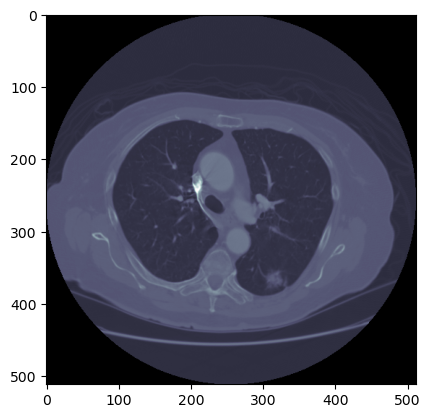

In [151]:
plt.imshow(dcm.pixel_array, cmap="bone")

## Image histogram
Before choosing threshold method let's investigate a histogram of our values.

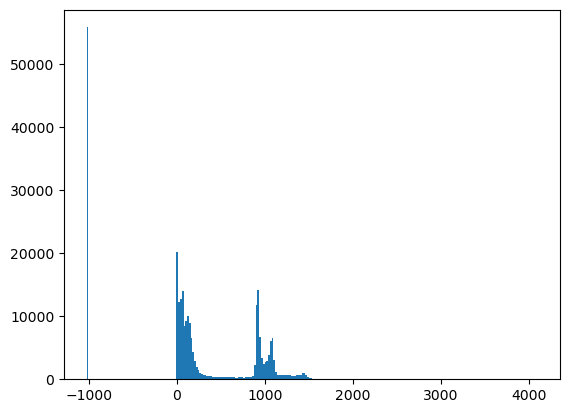

In [200]:
image = dcm.pixel_array
plt.hist(image.ravel(), bins=256)
plt.show()

We can notice a large amount of negative values, let's investigate what part of the image it corresponds to.

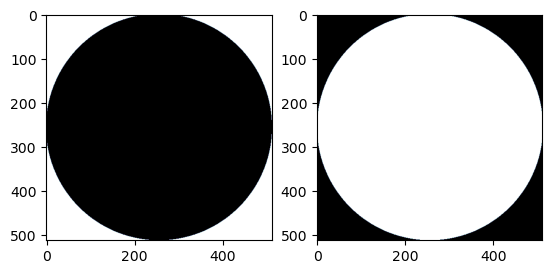

In [201]:
mask = image < 0
negative_values = image * mask

fig, axes = plt.subplots(ncols=2)

axes[0].imshow(mask, cmap="bone")
axes[1].imshow(negative_values, cmap="bone")
plt.show()

So our negative values are pixels outside of our actual image. Let's fix those outliers.

In [202]:
image = image * ~mask

Let's see how our histogram looks now.

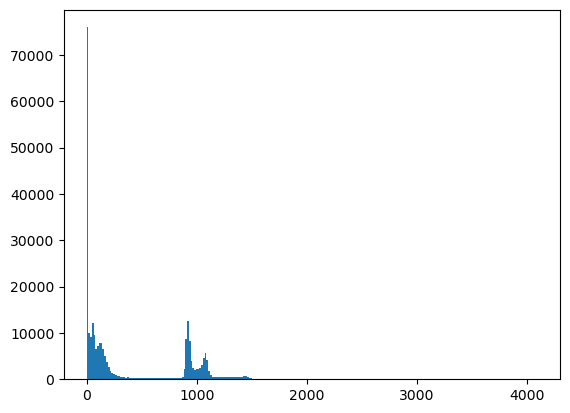

In [203]:
plt.hist(image.ravel(), bins=256)
plt.show()

There is a lot of zeroes, but this is expected as the actual image is a circle within.

## Threshold method selection
We can easly see results of multiple threshold methods by using `try_all_thresholds` from `scikit-image`.

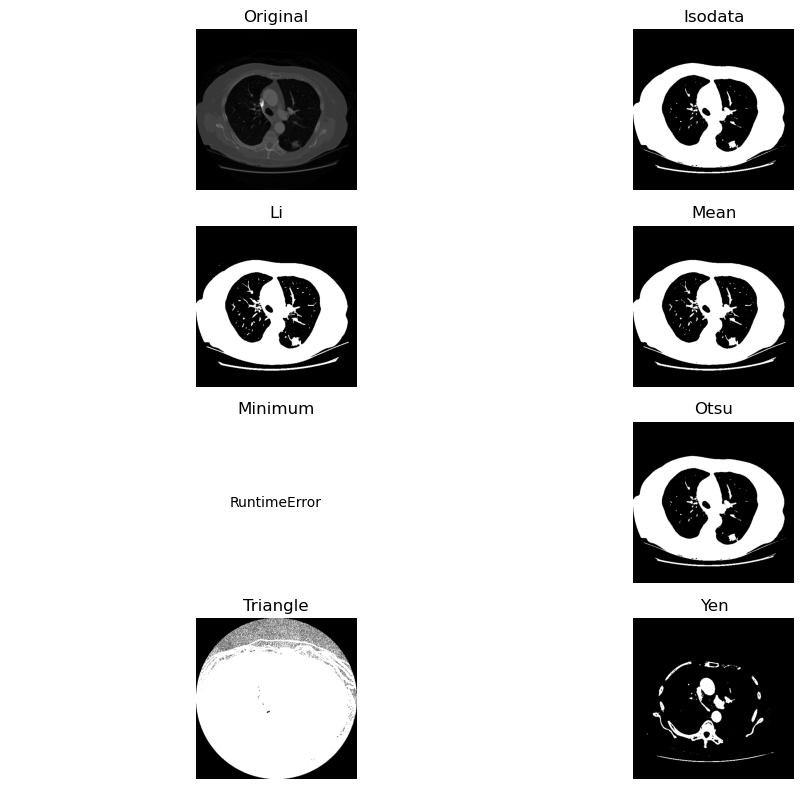

In [204]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(image, figsize=(10, 8), verbose=False)
plt.show()

For our segmentation we need a binary image with the most amount of space within the lungs. Both **Otsu** and **Isodata** methods seem to fulill our requirements. We will use the **Otsu** method for our segmentation.

## Define segmentation function

In [221]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import (
    remove_small_objects,
    remove_small_holes,
    binary_closing,
    binary_opening,
    disk,
)


def fix_outliers(dcm):
    """Returns dicom object without negative values"""
    image = dcm.pixel_array
    mask = image >= 0
    image = image * mask
    dcm.PixelData = image.tobytes()
    return dcm



def create_lung_mask(dcm):
    """Returns a binary mask and image from each step"""
    # Fix outliers and load dicom pixel array 
    dcm = fix_outliers(dcm)
    image = dcm.pixel_array

    # Select threshold using the Otsu method
    thresh = threshold_otsu(image)

    # Reverse binarization of the image 
    mask_binary = image < thresh

    # Remove border, now only lungs and some noise is visible
    mask_borderless = clear_border(mask_binary)

    # Remove small artifacts around lungs
    mask_without_objects = remove_small_objects(mask_borderless)

    # Fill holes within lungs
    mask_without_holes = remove_small_holes(mask_without_objects)

    # Binary closing remove larger holes
    mask_closed = binary_closing(mask_without_holes, disk(15))

    # Binary opening to disconnect lungs 
    mask_opened = binary_opening(mask_closed, disk(5))

    # Save each step in a list for visualization
    steps = [
        image,
        mask_binary,
        mask_borderless,
        mask_without_objects,
        mask_without_holes,
        mask_closed,
        mask_opened,
    ]
    
    return mask_opened, steps

## Mask result

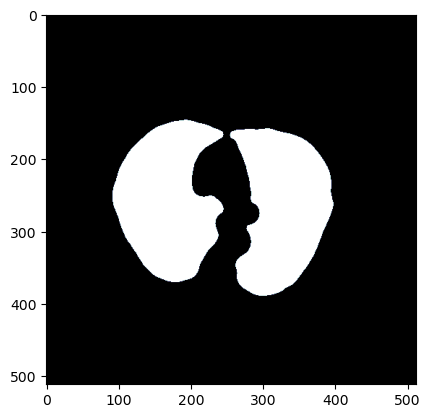

In [222]:
mask, steps = create_lung_mask(dcm)
plt.imshow(mask, cmap="bone")

## Each segmentation step

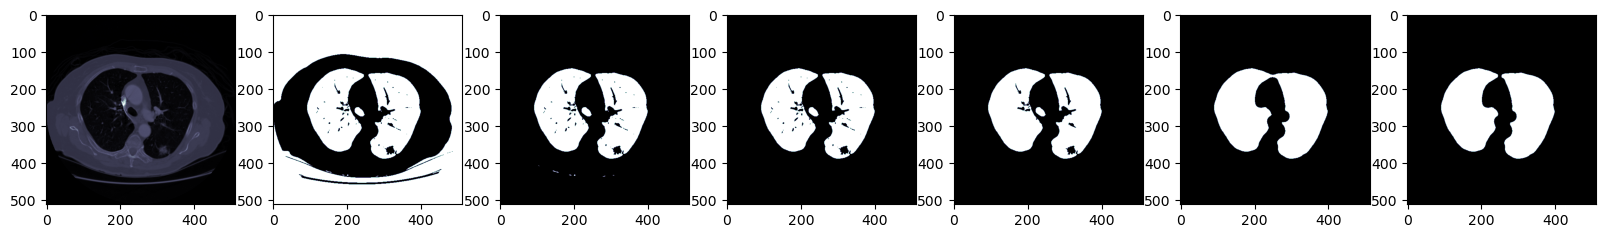

In [223]:
fig, axes = plt.subplots(nrows=1, ncols=len(steps), figsize=(20, 15))

for step, ax in zip(steps, axes):
    ax.imshow(step, cmap="bone")

## Final result
Now we can examine the segmented lungs and preprocess our dataset for further use.

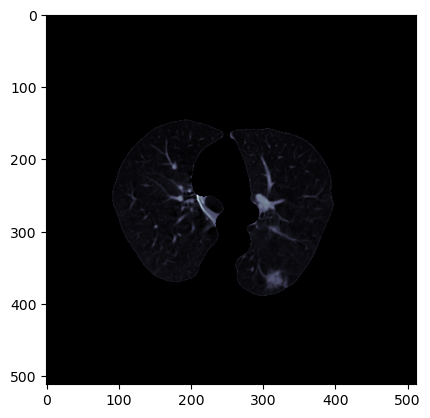

In [224]:
segmented_lungs = image * mask

plt.imshow(segmented_lungs, cmap="bone")